In [1]:
# Parameters
dataset = "MNIST" 
v_type = "mingd"
root_path = r"C:/Users/acsalunk/Downloads/DatasetInference/Dataset-Inference/files"
params_path = r"C:/Users/acsalunk/Downloads/DatasetInference/Dataset-Inference"
split_index = 500

In [2]:
from IPython.display import display, Markdown
v_type2disp = dict(mingd="MinGD", rand="Blind Walk")
display(Markdown(f"# {dataset} - mingd results"))

# MNIST - mingd results

In [3]:
!pip install torch

In [4]:
!pip install --user typing-extensions==4.3.0

In [5]:
import os, sys
sys.path.insert(0, params_path)

import argparse, params, time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from importlib import reload
from tqdm.auto import tqdm

import random

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

In [6]:
import seaborn as sns
import pandas as pd
import os

In [7]:
from scipy.stats import combine_pvalues, ttest_ind_from_stats, ttest_ind
from functools import reduce
from scipy.stats import hmean

## Use the full vectors to train a linear model

In [8]:
model_types = ['distillation', 'teacher']

In [9]:
names = ["teacher","student"]
trains = {}
tests = {}
for i in range(len(names)):
    temp_path = root_path + "/MNIST/" + names[i]
    print(temp_path)
    trains[names[i]] = (torch.load(f"{temp_path}/train_{v_type}_vulnerability_2.pt"))
    tests[names[i]] = (torch.load(f"{temp_path}/test_{v_type}_vulnerability_2.pt"))
mean_mnist = trains["teacher"].mean(dim = (0,1))
std_mnist = trains["teacher"].std(dim = (0,1))

C:/Users/acsalunk/Downloads/DatasetInference/Dataset-Inference/files/MNIST/teacher
C:/Users/acsalunk/Downloads/DatasetInference/Dataset-Inference/files/MNIST/student


In [10]:
if v_type == "mingd":
    for name in names:
        trains[name] = trains[name].sort(dim = 1)[0]
        tests[name] = tests[name].sort(dim = 1)[0]
        
for name in names:
    trains[name] = (trains[name]- mean_mnist)/std_mnist
    tests[name] = (tests[name]- mean_mnist)/std_mnist
    
f_num = 30
a_num=30

trains_n = {}
tests_n = {}
for name in names:
    trains_n[name] = trains[name].T.reshape(1000,f_num)[:,:a_num]
    tests_n[name] = tests[name].T.reshape(1000,f_num)[:,:a_num]

<ipython-input-10-a152a02d8fd4>:16: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3618.)
  trains_n[name] = trains[name].T.reshape(1000,f_num)[:,:a_num]


In [11]:
n_ex = split_index
train = torch.cat((trains_n["teacher"][:n_ex], tests_n["teacher"][:n_ex]), dim = 0)
y = torch.cat((torch.zeros(n_ex), torch.ones(n_ex)), dim = 0)

rand=torch.randperm(y.shape[0])
train = train[rand]
y = y[rand]

In [12]:
model = nn.Sequential(nn.Linear(a_num,100),nn.ReLU(),nn.Linear(100,1),nn.Tanh())
criterion = nn.CrossEntropyLoss()
optimizer =torch.optim.SGD(model.parameters(), lr=0.1)

In [13]:
with tqdm(range(1000)) as pbar:
    for epoch in pbar:
        optimizer.zero_grad()
        inputs = train
        outputs = model(inputs)
        loss = -1 * ((2*y-1)*(outputs.squeeze(-1))).mean()
        loss.backward()
        optimizer.step()
        pbar.set_description('loss {}'.format(loss.item()))

## Dataset Inference 

In [14]:
def get_p(outputs_train, outputs_test):
    pred_test = outputs_test[:,0].detach().cpu().numpy()
    pred_train = outputs_train[:,0].detach().cpu().numpy()
    tval, pval = ttest_ind(pred_test, pred_train, equal_var=False)
    if pval < 0:
        raise Exception(f"p-value={pval}")
    return pval

def get_p_values(num_ex, train, test, k):
    total = train.shape[0]
    sum_p = 0
    p_values = []
    positions_list = []
    for i in range(k):
        positions = torch.randperm(total)[:num_ex]
        p_val = get_p(train[positions], test[positions])
        positions_list.append(positions)
        p_values.append(p_val)
    return p_values

def get_fischer(num_ex, train, test, k):
    p_values = get_p_values(num_ex, train, test, k)
    return combine_pvalues(p_values, method="mudholkar_george")[1]

def get_max_p_value(num_ex, train, test, k):
    p_values = get_p_values(num_ex, train, test, k)
    return max(p_values)

In [15]:
outputs_tr = {}
outputs_te = {}
for name in names:
    outputs_tr[name] = model(trains_n[name])
    outputs_te[name] = model(tests_n[name])

In [16]:
import scipy.stats as stats
def print_inference(outputs_train, outputs_test):
    m1, m2 = outputs_test[:,0].mean(), outputs_train[:,0].mean()
    pval = get_p(outputs_train, outputs_test)
    print(f"p-value = {pval} \t| Mean difference = {m1-m2}")

In [17]:
for name in names:
    outputs_tr[name], outputs_te[name] = outputs_tr[name][split_index:], outputs_te[name][split_index:]

In [18]:
for name in names:
    print(f"{name}")
    print_inference(outputs_tr[name], outputs_te[name])

teacher
p-value = 2.978426705729042e-12 	| Mean difference = 0.26961424946784973
student
p-value = 4.063363769769808e-12 	| Mean difference = 0.266294002532959


In [19]:
if not os.path.exists(f"{dataset}_{v_type}.h5"):
    total_reps = 40
    max_m = 45
    total_inner_rep = 100

    m_list = [x for x in range(2, max_m, 1)]
    p_values_all_threat_models_dict = {}

    n_pbar = tqdm(names, leave=False)
    for name in n_pbar:
        p_vals_per_rep_no = {}
        r_pbar = tqdm(range(total_reps), leave=False)
        for rep_no in r_pbar:
            p_values_list = []
            for m in m_list:
                p_list = get_p_values(m, outputs_tr[name], outputs_te[name], total_inner_rep)
                try:
                    hm = hmean(p_list)
                except:
                    hm = 1.0
                p_values_list.append(hm)
                pbar.set_description(f"{rep_no: 2d} {name} m={m: 3d}: f{hm: 0.5f}")
            r_pbar.set_description(f"rep_no: {rep_no+1}/{total_reps}")
            p_vals_per_rep_no[rep_no] = p_values_list
        p_values_all_threat_models_dict[name] = p_vals_per_rep_no
        
    df_list = []
    for name, rep_dict in p_values_all_threat_models_dict.items():
        df = pd.DataFrame(rep_dict).reset_index().assign(m=lambda r: r.index+2).drop(["index"], axis=1)
        df_list.append(pd.melt(df,id_vars=["m"], var_name="rep_no", value_name="p_value").assign(threat_model=name))
    results_df = pd.concat(df_list)
    
    results_df.to_hdf(f"{dataset}_{v_type}.h5", v_type)
    results_df
else:
    results_df = pd.read_hdf(f"{dataset}_{v_type}.h5", v_type)

### Plotting

In [20]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['text.latex.preamble'] = r'\usepackage{times}'

plt.rcParams.update({
    "text.usetex": True,
})

### Renaming

In [21]:
rename_dict = {
    "threat_model": "Threat Model", 
    "teacher": "Source", 
    "distillation": "Distillation", 
    "extract-label": "Label-Query", 
    "extract-logit": "Logit-Query", 
    "zero-shot": "Zero-Shot Learning",
    "fine-tune": "Fine-Tuning",
    "pre-act-18": "Diff. Architecture",
    }

In [22]:
plot_df = (results_df.rename(columns=rename_dict).replace(rename_dict)
           .query('(m >= 5)')
          )

In [27]:
print(plot_df)

       m  rep_no   p_value Threat Model
3      5       0  0.141524       Source
4      6       0  0.053071       Source
5      7       0  0.049553       Source
6      8       0  0.076193       Source
7      9       0  0.098495       Source
...   ..     ...       ...          ...
1715  40      39  0.000944      student
1716  41      39  0.000285      student
1717  42      39  0.000364      student
1718  43      39  0.001854      student
1719  44      39  0.001283      student

[3200 rows x 4 columns]


In [23]:
# Sizes
SMALL_SIZE = 14
MEDIUM_SIZE = SMALL_SIZE + 1
BIGGER_SIZE = MEDIUM_SIZE + 1
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsi ze of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [24]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [28]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

Text(0, 0.5, 'p-value')

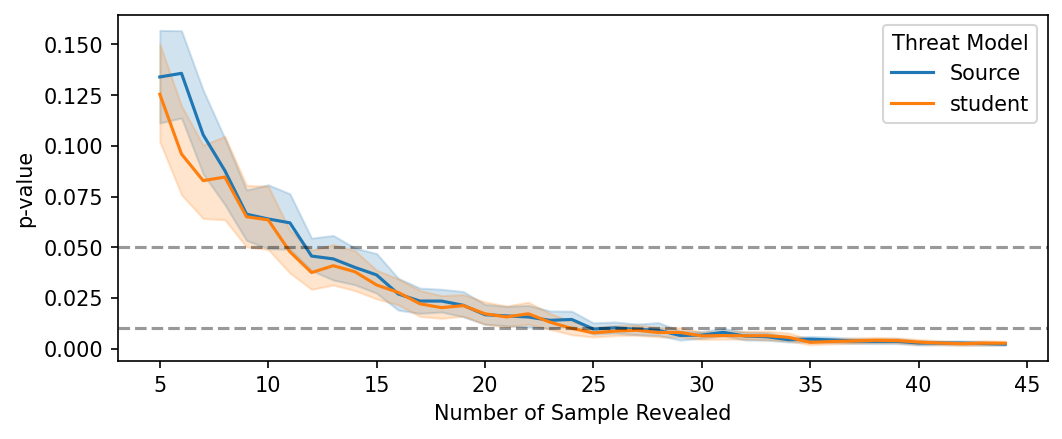

In [29]:
fig, ax = plt.subplots(figsize=(8, 3), dpi=150)
g = sns.lineplot(x="m", y="p_value", hue="Threat Model", data=plot_df, ax=ax, ci=99)
g.axhline(0.05, ls='--', color="black", alpha=0.4)
g.axhline(0.01, ls='--', color="black", alpha=0.4)
g.set_xlabel("Number of Sample Revealed")
g.set_ylabel("p-value")

## Table

In [26]:
tab = generate_table(selected_m=10, outputs_te=outputs_te, outputs_tr=outputs_tr, names=names)

NameError: name 'generate_table' is not defined

In [ ]:
with pd.option_context("display.float_format", lambda x: f"{x: 0.3f}"):
    print(tab)

In [ ]:
with pd.option_context("display.float_format", lambda x: f"{x: 0.3f}"):
    print(tab.to_latex(formatters=dict(mean_diff="{:0.3f}".format, p_value=lambda x: "$10^{"+f"{x:0.0E}"[2:]+"}$"), escape=False))